In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import json
import os
from shutil import move, copy

from ultralytics import YOLO

In [4]:
data = pd.read_csv('annots_imgs_merged.csv')
dot = data[data['chart-type'] == 'dot']
dot = dot.head(3000)
dot = dot[['data-series','visual-elements.dot points','file_name','image_path']]
dot.columns = ['data_series','data_coords','name','path']
dot.reset_index(drop=True, inplace=True)
dot.head()

,data_series,data_coords,name,path
0,"[{'x': '1900', 'y': 9}, {'x': '2000', 'y': 5},...","[[{'x': 113.33333333333333, 'y': 232.199999999...",722775563cdf,../data/interim/Dotplots/722775563cdf.jpg
1,"[{'x': 'Plot 169', 'y': 2}, {'x': 'Plot 170', ...","[[{'x': 111.33333333333333, 'y': 233.0}, {'x':...",541072efa16e,../data/interim/Dotplots/541072efa16e.jpg
2,"[{'x': '1985', 'y': 6}, {'x': '1992', 'y': 5},...","[[{'x': 118.39999999999999, 'y': 237.386666666...",08b5c8e2dc12,../data/interim/Dotplots/08b5c8e2dc12.jpg
3,"[{'x': 'Sasvad', 'y': 9}, {'x': 'Soron', 'y': ...","[[{'x': 102.4, 'y': 67.71666666666667}, {'x': ...",75acb35b82b5,../data/interim/Dotplots/75acb35b82b5.jpg
4,"[{'x': '1985', 'y': 7}, {'x': '1992', 'y': 3},...","[[{'x': 118.0, 'y': 113.23333333333335}, {'x':...",87acdd66b8e5,../data/interim/Dotplots/87acdd66b8e5.jpg


In [5]:
path = '/home/ubuntu/project/Dotplots'
filenames = dot['name'].values
new_paths = []
for file in filenames:
    new_path = os.path.join(path,file)+'.jpg'
    new_paths.append(new_path)

dot['path'] = new_paths
dot.head()

,data_series,data_coords,name,path
0,"[{'x': '1900', 'y': 9}, {'x': '2000', 'y': 5},...","[[{'x': 113.33333333333333, 'y': 232.199999999...",722775563cdf,/home/ubuntu/project/Dotplots/722775563cdf.jpg
1,"[{'x': 'Plot 169', 'y': 2}, {'x': 'Plot 170', ...","[[{'x': 111.33333333333333, 'y': 233.0}, {'x':...",541072efa16e,/home/ubuntu/project/Dotplots/541072efa16e.jpg
2,"[{'x': '1985', 'y': 6}, {'x': '1992', 'y': 5},...","[[{'x': 118.39999999999999, 'y': 237.386666666...",08b5c8e2dc12,/home/ubuntu/project/Dotplots/08b5c8e2dc12.jpg
3,"[{'x': 'Sasvad', 'y': 9}, {'x': 'Soron', 'y': ...","[[{'x': 102.4, 'y': 67.71666666666667}, {'x': ...",75acb35b82b5,/home/ubuntu/project/Dotplots/75acb35b82b5.jpg
4,"[{'x': '1985', 'y': 7}, {'x': '1992', 'y': 3},...","[[{'x': 118.0, 'y': 113.23333333333335}, {'x':...",87acdd66b8e5,/home/ubuntu/project/Dotplots/87acdd66b8e5.jpg


In [6]:
dot.shape

(3000, 4)

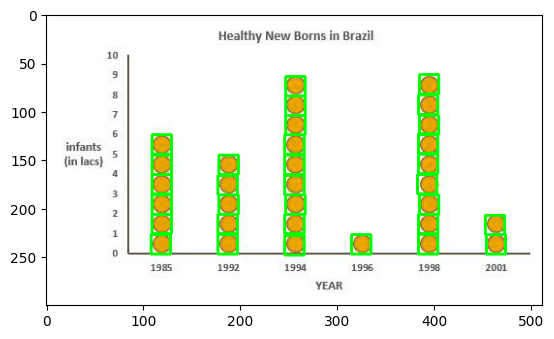

In [5]:
coords = dot['data_coords'][2]
coords = coords.replace("'", "\"")
coords_list = json.loads(coords)

    # extract important image info
path = dot['path'][2]
name = dot['name'][2]
img = cv2.imread(path)
height = img.shape[0]
width = img.shape[1]

    # Save the xy coords into a list
xy_coords = []
for data_point in coords_list[0]:
    xy_coords.append((data_point['x']-10,data_point['y']-10, data_point['x']+10, data_point['y']+10))


dot_img = img.copy()
for bbox in xy_coords:
            x1, y1, x2, y2 = bbox
            x1 = int(x1)
            x2 = int(x2)
            y1 = int(y1)
            y2 = int(y2)
            cv2.rectangle(dot_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(dot_img)
plt.show()

    

In [7]:
dataframes = []
for i in range(len(dot)):
    # extract xy coordinates from data_coords column
    coords = dot['data_coords'][i]
    coords = coords.replace("'", "\"")
    coords_list = json.loads(coords)

    # extract important image info
    path = dot['path'][i]
    name = dot['name'][i]
    img = cv2.imread(path)
    height = img.shape[0]
    width = img.shape[1]

    # Save the xy coords into a list
    xy_coords = []
    for data_point in coords_list[0]:
        xy_coords.append((data_point['x'],data_point['y']))

    # Transform the xy coords into YOLO bboxes 
    bboxes = []
    for xy in xy_coords:
        x, y = xy
        bbox = (int(x)/width, int(y)/height, 20/width, 20/height)
        bboxes.append(bbox)

    # Save into list of dataframe
    yolo = pd.DataFrame(bboxes, columns=['x','y','w','h'])
    yolo['class'] = 0
    yolo['path'] = path
    yolo['name'] = name
    yolo = yolo[['path','name','class','x','y','w','h']]
    dataframes.append(yolo)

# Concat dataframes and check that the number of unique images is correct
yolo_df = pd.concat(dataframes)
yolo_df['path'].nunique()

3000

In [8]:
yolo_df.head()

,path,name,class,x,y,w,h
0,/home/ubuntu/project/Dotplots/722775563cdf.jpg,722775563cdf,0,0.226,0.789116,0.04,0.068027
1,/home/ubuntu/project/Dotplots/722775563cdf.jpg,722775563cdf,0,0.224,0.721088,0.04,0.068027
2,/home/ubuntu/project/Dotplots/722775563cdf.jpg,722775563cdf,0,0.224,0.656463,0.04,0.068027
3,/home/ubuntu/project/Dotplots/722775563cdf.jpg,722775563cdf,0,0.224,0.581633,0.04,0.068027
4,/home/ubuntu/project/Dotplots/722775563cdf.jpg,722775563cdf,0,0.224,0.510204,0.04,0.068027


In [9]:
unique_images = yolo_df['path'].unique()
img_df = pd.DataFrame(unique_images,columns=['path'])
img_train = tuple(img_df.sample(frac=0.8)['path'])
img_test = tuple(img_df.query(f'path not in {img_train}')['path'])
len(img_train), len(img_test)

(2400, 600)

In [10]:
train_df = yolo_df.query(f'path in {img_train}')
test_df = yolo_df.query(f'path in {img_test}')

In [11]:
src_folder = '/home/ubuntu/project/Dotplots'
train_folder = '/home/ubuntu/project/train'
test_folder = '/home/ubuntu/project/test'

In [12]:
cols = ['name','class','x','y','w','h']
groupby_obj_train = train_df[cols].groupby('name')
groupby_obj_test = test_df[cols].groupby('name')

In [13]:
def save_data(filename, folder_path, group_obj):
    #copy image
    src = os.path.join(src_folder,filename)+'.jpg'
    dst = os.path.join(folder_path, filename)+'.jpg'
    move(src, dst)

    #save labels
    text_filename = os.path.join(folder_path,filename+'.txt')
    group_obj.get_group(filename).set_index('name').to_csv(text_filename, index=False, header=False, sep=' ')

In [14]:
filename_series = pd.Series(groupby_obj_train.groups.keys())
filename_series.apply(save_data,args=(train_folder, groupby_obj_train))

0       None
1       None
2       None
3       None
4       None
        ... 
2395    None
2396    None
2397    None
2398    None
2399    None
Length: 2400, dtype: object

In [15]:
filename_series_test = pd.Series(groupby_obj_test.groups.keys())
filename_series_test.apply(save_data,args=(test_folder, groupby_obj_test))

0      None
1      None
2      None
3      None
4      None
       ... 
595    None
596    None
597    None
598    None
599    None
Length: 600, dtype: object

In [2]:
from ultralytics import YOLO
model = YOLO('yolov8n.yaml')
# model = YOLO('yolov8s-p2.yaml').load('yolov8s.pt')


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

In [3]:
model.train(data='/home/ubuntu/project/data.yaml', epochs=5)

Ultralytics YOLOv8.0.136 🚀 Python-3.8.10 torch-2.0.1+cu117 CPU (Intel Xeon E5-2666 v3 2.90GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/home/ubuntu/project/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False,